# Проект "Предсказание количества заказлов такси"

## Описание проекта <a id='0'> </a>

**Заказчик**: компания «Чётенькое такси»

**Данные**: исторические данные о заказах такси в аэропортах

**Запрос заказчика**: привлекать больше водителей в период пиковой нагрузки

**Цель проекта**: построить модель машинного обучения, которая будет прогнозировать количество заказов такси на следующий час


**Критерий качества модели**: Значение метрики RMSE на тестовой выборке должно быть не больше 48

**План проекта**:  
- [Описание проекта](#0)
- [Описание и загрузка данных](#1)
- [Изучение и предобработка данных](#2)
- [Исследовательский и корреляционный анализ данных](#3)
- [Подготовка данных к обучению](#4)
- [Обучение моделей](#5)
- [Вывод](#6)

In [1]:
# import library
import math
import os
import time
from datetime import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import uniform, randint
from statsmodels.tsa.seasonal import seasonal_decompose

import phik
from phik.report import plot_correlation_matrix

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

!pip install -q --upgrade scikit-learn

## Описание и загрузка данных <a id='1'> </a>

Таблица с данными содержит следующие признаки:
- `datetime` (индекс) — момент времени
- `num_orders` — количество заказов в момент времени

In [2]:
def csv_reader(pth):
    if os.path.exists(pth):
        return pd.read_csv(pth, index_col=[0], parse_dates=[0])
    elif os.path.exists(os.path.join('/datasets', pth)):
        return pd.read_csv(os.path.join('/datasets', pth), index_col=[0], parse_dates=[0])
    
df = csv_reader('taxi.csv')

## Изучение и предобработка данных <a id='2'> </a>

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Момент времени разеделн по 10-минутам. Записей в таблице - 26496. Типы данных в порядке.

In [5]:
df.isna().sum()

num_orders    0
dtype: int64

Пропусков нет.

Отсортируем данные и проведём ресемплирование по одному часу:

In [6]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

/var/folders/_n/bj15yv052w14dr5hrs2kr2qm0000gn/T/ipykernel_67239/1523532566.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').sum()


In [7]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
df.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


<div class="alert"; style="border-left: 7px solid pink">

**Мини-вывод**

- Данные первично изучены и предобработаны:
    - Данные представлены за `6 месяцев`: с `1 марта 2018` по `31 августа 2018`
    - Данные `отсортированы` по возрастанию времени
    - Проведено `ресемплирование по одному часу`
    - В обработанной выборке `4416` записи
    - Типы данных `верные`
    - Пропусков `нет`
</div>

## Исследовательский анализ данных <a id='3'> </a>

Проанализуем полдробнее данные. Взглянем на основные статистики признака:

In [9]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


**Заметим, что**:
- в `среднем` за час делают `84 заказа`
- в данных есть часы, когда такси `не заказывали`
- `максимальное` число заказов за час в привелённых данных - `465`

Построим графики, которые описывают временные ряды:

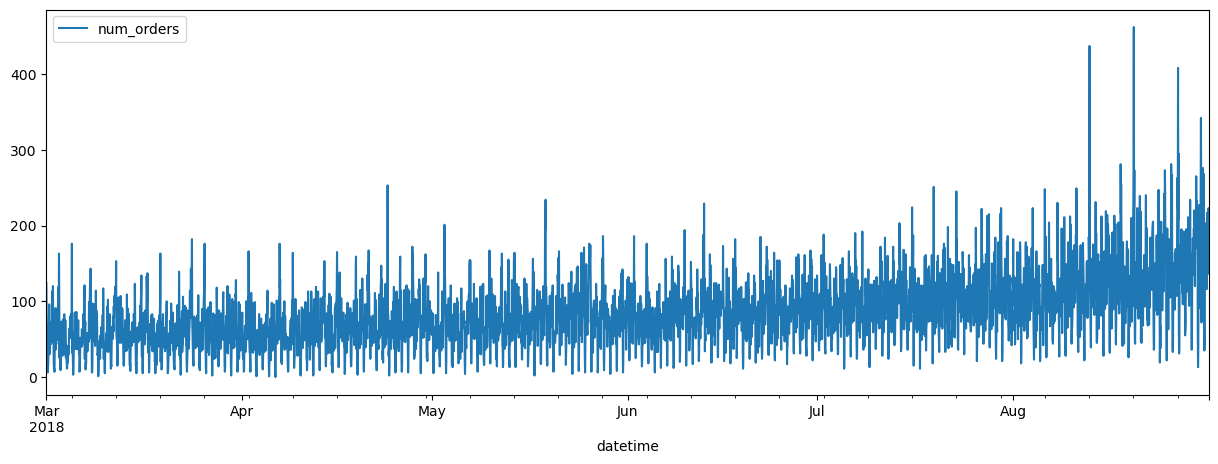

In [10]:
df.plot(figsize = (15, 5));

Добавим в таблицу `скользящее среднее` и `скользящее отклонение` с `размером окна`, равным `24` (сутки), чтобы складить данные:

In [11]:
df['rolling_mean'] = df['num_orders'].shift().rolling(24).mean()
df['rolling_std'] = df['num_orders'].shift().rolling(24).std()

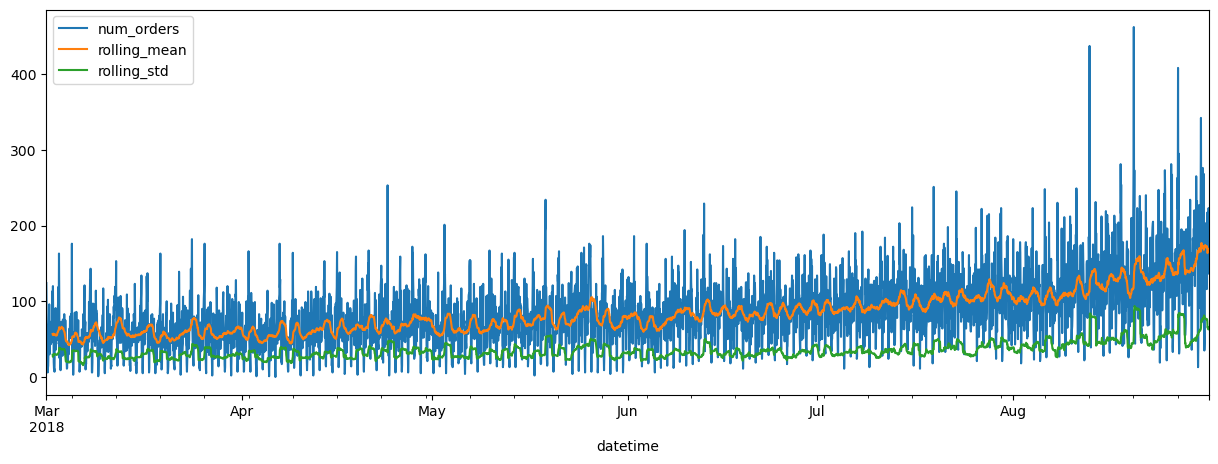

In [12]:
df.plot(figsize=(15, 5));

**Заметим, что**:
- что временной ряд стохастического процесса `не является стационарным`, потому что со временем меняется среднее и стандартное отклонение
- `Сезонность` в представленных данных `проследить не получится`, поскольку информация дана только за полгода
- Можно отметить `тренд` на `рост` количества заказов `ближе к лету` с легким проседанием в июле и в августе. При этом присутствуют большое количество дней, когда было сделано выбивающееся из общего тренда количество заказов

Декомпозируем данные:

In [13]:
decomposed = seasonal_decompose(df['num_orders'])

Посмотрим суточную сезонность:

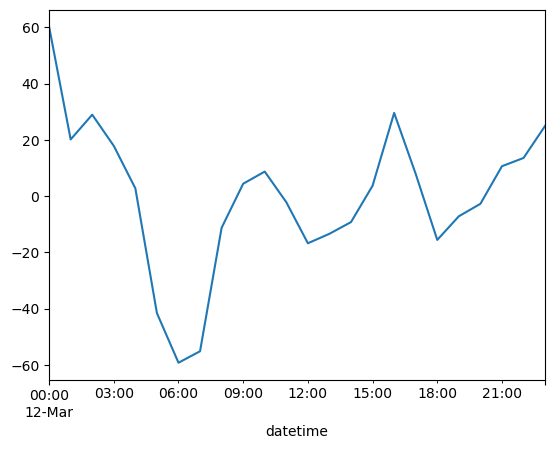

In [14]:
decomposed.seasonal['2018-03-12']
decomposed.seasonal['2018-03-12'].plot(ax=plt.gca());

Можно заметить следующую суточную активность:
- в `12 часов` ночи `наибольшее` количество заказов - вероятно, люди `чаще прилетают` в это время
- `6 утра` (+- 1 час) - `наименее` популярное время для заказов такси в аэропорту, лучше много авто в данный промежуток `не задействовать`
- второй по значимости пик `с 15 до 17` - скорее всего, это дневные прилеты, поэтому в этом время чаще заказывают такси
- в `12 дня` и `18 часов` вечера `не так много` такси, но больше чем в 6 часов
- `с 18` количество заказов начинает постепенно расти

Посмотрим недельную сезонность:

In [15]:
decomposed = seasonal_decompose(df['num_orders'].resample('1D').sum())

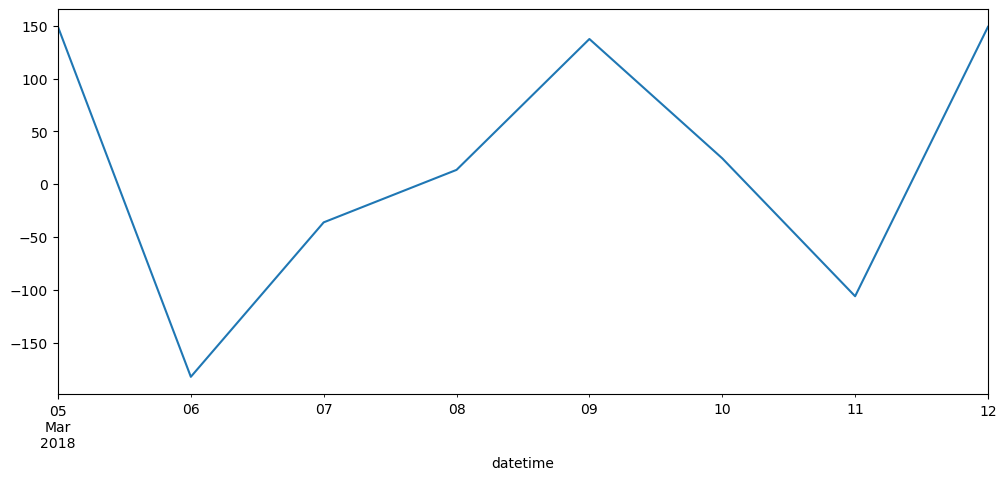

In [16]:
decomposed.seasonal['2018-03-05':'2018-03-12'].plot(ax=plt.gca(), figsize=(12, 5));

Заметим недельную сезонность: в `воскресенье` заказывают `меньше`, чем с понеделька по пятницу.

Далее разложим временной ряд на `тренд`:

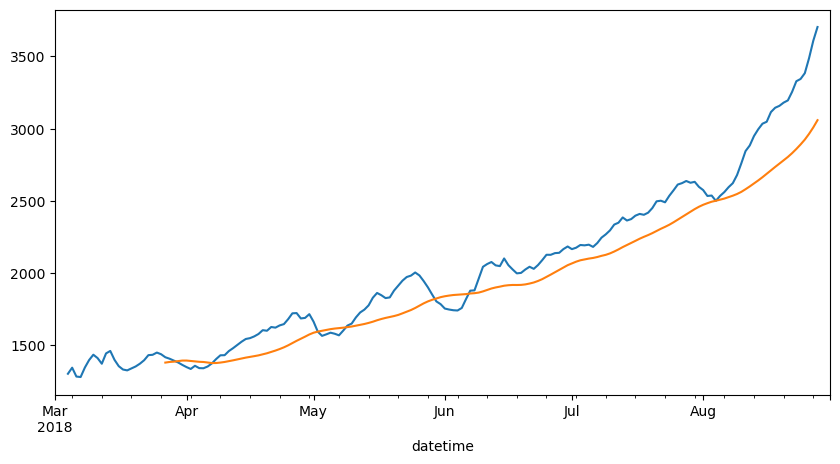

In [17]:
decomposed.trend.plot(ax=plt.gca())
decomposed.trend.rolling(24).mean().plot(ax=plt.gca(), figsize=(10, 5))
None

Далее разложим временной ряд на `остатки`:

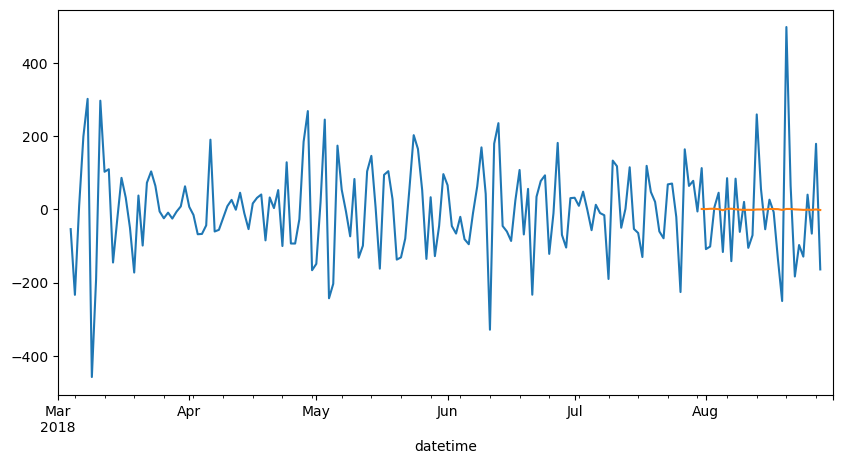

In [18]:
decomposed.resid.plot(ax=plt.gca())
decomposed.resid.rolling(150).mean().plot(ax=plt.gca(), figsize=(10, 5));

Посмотрим на среднее количество заказов за каждый месяц с марта по август:

In [19]:
df['month'] = df.index.month
display(pd.DataFrame(df.groupby('month')['num_orders'].sum()))

,num_orders
month,
3,42768
4,45939
5,54820
6,59906
7,74405
8,94973


Тренд `подтвержден`: с март по август среднее количество заказов растет с `CAGR` (среднемесячный темп роста)
равным `14,22%`. Вместе с тем, присутсвуют много `необъясненных остатков`.

<div class="alert"; style="border-left: 7px solid pink">

**Мини-вывод**

- в `среднем` за час делают `84 заказа`
- в данных есть часы, когда такси `не заказывали`
- `максимальное` число заказов за час в привелённых данных - `465`
- анализ данных выявил `тренд`: с `марта` по `август` среднее количество заказов `растет` с `CAGR` = `14,22%`;
- анализ данных выявил `2 сезонности`:
    - `суточная`:
        - в `12 часов` ночи `наибольшее` количество заказов - вероятно, люди `чаще прилетают` в это время
        - `6 утра` (+- 1 час) - `наименее` популярное время для заказов такси в аэропорту, лучше много авто в данный промежуток `не задействовать`
        - второй по значимости пик `с 15 до 17` - скорее всего, это дневные прилеты, поэтому в этом время чаще заказывают такси
        - в `12 дня` и `18 часов` вечера `не так много` такси, но больше чем в 6 часов
        - `с 18` количество заказов начинает постепенно расти
    - `недельная`:
        - в `воскресенье` заказывают стабильно `меньше`, чем с понеделька по пятницу

</div>

## Подготовка данных к обучению <a id='4'> </a>

Удалим ранее добавленный признак "месяц":

In [20]:
df.drop(['month'], axis=1, inplace=True)

In [21]:
df.head()

,num_orders,rolling_mean,rolling_std
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN


Напишем функцию, которая добавляет новые признаки: `год`, `месяц`, `день` и `день недели`:

In [22]:
def make_features(data, max_lag, rolling_mean_size):
    data = data.copy()
    data['hour'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    return data

In [23]:
def df_split(df):
    train, test = train_test_split(df, shuffle=False, test_size=0.1)
    train.dropna(inplace=True)
    
    X_train = train.drop(['num_orders'], axis=1)
    y_train = train['num_orders']
    
    X_test = test.drop(['num_orders'], axis=1)
    
    y_test = test['num_orders']
    
    return X_train, X_test, y_train, y_test

<div class="alert"; style="border-left: 7px solid pink">

**Мини-вывод**

- в данные добавлены новые признаки: `скользящее среднее`, `стандартное отклонение`, `год`, `месяц`, `день` и `день недели`;
- убраны `записи с пропусками`, появившимися в результате `добавления` "скользящих" значений.

</div>

## Обучение моделей <a id='5'> </a>

Исползьзуем при обучении гиперпараметры max_lag, rolling_mean_size равными 24 (сутки) или 168 (неделя):

### max_lag = `24` и rolling_mean_size = `24`

In [24]:
df_new = make_features(df, 24, 24)

X_train, X_test, y_train, y_test = df_split(df_new)

ord_columns = ['hour', 'dayofweek']

num_columns = list(set(df_new.columns) - set(ord_columns) - set(['num_orders']))

In [25]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[list(range(1, 32)), list(range(7))], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns),
        ('ord', ord_pipe, ord_columns)
    ], 
    remainder='passthrough'
)

In [26]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [27]:
RANDOM_STATE = 42

param_distributions = [
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True, False],
        'models__copy_X': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': randint(1, 20),
        'models__min_samples_split': randint(2, 20),
        'models__min_samples_leaf': randint(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(2, 25),
        'models__max_depth': [5, 10, 15, 20],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }   
]

In [28]:
tscv = TimeSeriesSplit(n_splits=5)
rs_24_24 = RandomizedSearchCV(
    pipe_final,
    param_distributions = param_distributions,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    random_state=RANDOM_STATE
)

rs_24_24.fit(X_train, y_train) 

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['lag_4',
                                                                                'lag_14',
                                                                                'rolling_mean',
                                                                                'lag_3',
                                                                                'lag_12',
                                                                                'lag_1',
                                                                                'lag_10',
                                                                                'lag_17',
                                                                                'lag_24',
                                                                                'lag_20',
                                                                                'lag_9',
                                                                                'lag_7',
                                                                                'lag_18',
                                                                                'lag_5',
                                                                                'lag_6',
                                                                                'l...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [RandomForestRegressor(random_state=42)],
                                         'models__max_depth': [5, 10, 15, 20],
                                         'models__min_samples_leaf': [1, 2, 4],
                                         'models__min_samples_split': [2, 5,
                                                                       10],
                                         'models__n_estimators': range(2, 25),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [29]:
print('Метрика RMSE для лучшей модели:\n', round(abs(rs_24_24.best_score_), 2))

Метрика RMSE для лучшей модели:
 26.92


Выведем топ лучших моделей по результатам кросс-валидации:

In [30]:
result = pd.DataFrame(rs_24_24.cv_results_)
display(result[['rank_test_score', 'param_models', 'mean_test_score','params']]
        .sort_values('rank_test_score').head())

,rank_test_score,param_models,mean_test_score,params
0,1,RandomForestRegressor(random_state=42),-26.918286,{'models': RandomForestRegressor(random_state=...
7,2,LinearRegression(),-27.158274,"{'models': LinearRegression(), 'models__copy_X..."
4,3,LinearRegression(),-27.158274,"{'models': LinearRegression(), 'models__copy_X..."
2,4,RandomForestRegressor(random_state=42),-27.819375,{'models': RandomForestRegressor(random_state=...
8,5,RandomForestRegressor(random_state=42),-27.920750,{'models': RandomForestRegressor(random_state=...


### max_lag = `24` и rolling_mean_size = `168`

In [31]:
df_new = make_features(df, 24, 168)

X_train, X_test, y_train, y_test = df_split(df_new)

ord_columns = ['hour', 'dayofweek']

num_columns = list(set(df_new.columns) - set(ord_columns) - set(['num_orders']))

In [32]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[list(range(1, 32)), list(range(7))], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns),
        ('ord', ord_pipe, ord_columns)
    ], 
    remainder='passthrough'
)

In [33]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [34]:
param_distributions = [
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True, False],
        'models__copy_X': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': randint(1, 20),
        'models__min_samples_split': randint(2, 20),
        'models__min_samples_leaf': randint(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(2, 25),
        'models__max_depth': [5, 10, 15, 20],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }   
]

In [35]:
tscv = TimeSeriesSplit(n_splits=5)
rs_24_168 = RandomizedSearchCV(
    pipe_final,
    param_distributions = param_distributions,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    random_state=RANDOM_STATE
)

rs_24_168.fit(X_train, y_train) 

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['lag_4',
                                                                                'lag_14',
                                                                                'rolling_mean',
                                                                                'lag_3',
                                                                                'lag_12',
                                                                                'lag_1',
                                                                                'lag_10',
                                                                                'lag_17',
                                                                                'lag_24',
                                                                                'lag_20',
                                                                                'lag_9',
                                                                                'lag_7',
                                                                                'lag_18',
                                                                                'lag_5',
                                                                                'lag_6',
                                                                                'l...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [RandomForestRegressor(random_state=42)],
                                         'models__max_depth': [5, 10, 15, 20],
                                         'models__min_samples_leaf': [1, 2, 4],
                                         'models__min_samples_split': [2, 5,
                                                                       10],
                                         'models__n_estimators': range(2, 25),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [36]:
print('Метрика RMSE для лучшей модели:\n', round(abs(rs_24_168.best_score_), 2))

Метрика RMSE для лучшей модели:
 26.92


Выведем топ лучших моделей по результатам кросс-валидации:

In [37]:
result = pd.DataFrame(rs_24_168.cv_results_)
display(result[['rank_test_score', 'param_models', 'mean_test_score','params']]
        .sort_values('rank_test_score').head())

,rank_test_score,param_models,mean_test_score,params
0,1,RandomForestRegressor(random_state=42),-26.918286,{'models': RandomForestRegressor(random_state=...
7,2,LinearRegression(),-27.158274,"{'models': LinearRegression(), 'models__copy_X..."
4,3,LinearRegression(),-27.158274,"{'models': LinearRegression(), 'models__copy_X..."
2,4,RandomForestRegressor(random_state=42),-27.819375,{'models': RandomForestRegressor(random_state=...
8,5,RandomForestRegressor(random_state=42),-27.920750,{'models': RandomForestRegressor(random_state=...


### max_lag = `168` и rolling_mean_size = `24`

In [38]:
df_new = make_features(df, 168, 24)

X_train, X_test, y_train, y_test = df_split(df_new)

ord_columns = ['hour', 'dayofweek']

num_columns = list(set(df_new.columns) - set(ord_columns) - set(['num_orders']))

/var/folders/_n/bj15yv052w14dr5hrs2kr2qm0000gn/T/ipykernel_67239/3842793200.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
/var/folders/_n/bj15yv052w14dr5hrs2kr2qm0000gn/T/ipykernel_67239/3842793200.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
/var/folders/_n/bj15yv052w14dr5hrs2kr2qm0000gn/T/ipykernel_67239/3842793200.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

In [39]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[list(range(1, 32)), list(range(7))], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns),
        ('ord', ord_pipe, ord_columns)
    ], 
    remainder='passthrough'
)

In [40]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [41]:
param_distributions = [
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True, False],
        'models__copy_X': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': randint(1, 20),
        'models__min_samples_split': randint(2, 20),
        'models__min_samples_leaf': randint(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(2, 25),
        'models__max_depth': [5, 10, 15, 20],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }   
]

In [42]:
tscv = TimeSeriesSplit(n_splits=5)
rs_168_24 = RandomizedSearchCV(
    pipe_final,
    param_distributions = param_distributions,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    random_state=RANDOM_STATE
)

rs_168_24.fit(X_train, y_train) 

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['lag_168',
                                                                                'lag_55',
                                                                                'lag_123',
                                                                                'lag_105',
                                                                                'lag_107',
                                                                                'lag_20',
                                                                                'lag_167',
                                                                                'lag_6',
                                                                                'lag_80',
                                                                                'lag_8',
                                                                                'rolling_std',
                                                                                'lag_33',
                                                                                'lag_90',
                                                                                'lag_45',
                                                                                'l...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [RandomForestRegressor(random_state=42)],
                                         'models__max_depth': [5, 10, 15, 20],
                                         'models__min_samples_leaf': [1, 2, 4],
                                         'models__min_samples_split': [2, 5,
                                                                       10],
                                         'models__n_estimators': range(2, 25),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [43]:
print('Метрика RMSE для лучшей модели:\n', round(abs(rs_168_24.best_score_), 2))

Метрика RMSE для лучшей модели:
 22.58


Выведем топ лучших моделей по результатам кросс-валидации:

In [44]:
result = pd.DataFrame(rs_168_24.cv_results_)
display(result[['rank_test_score', 'param_models', 'mean_test_score','params']]
        .sort_values('rank_test_score').head())

,rank_test_score,param_models,mean_test_score,params
7,1,LinearRegression(),-22.578750,"{'models': LinearRegression(), 'models__copy_X..."
4,2,LinearRegression(),-22.580931,"{'models': LinearRegression(), 'models__copy_X..."
8,3,RandomForestRegressor(random_state=42),-23.491984,{'models': RandomForestRegressor(random_state=...
0,4,RandomForestRegressor(random_state=42),-24.087904,{'models': RandomForestRegressor(random_state=...
2,5,RandomForestRegressor(random_state=42),-24.955999,{'models': RandomForestRegressor(random_state=...


### max_lag = `168` и rolling_mean_size = `168`

In [45]:
df_new = make_features(df, 168, 168)

X_train, X_test, y_train, y_test = df_split(df_new)

ord_columns = ['hour', 'dayofweek']

num_columns = list(set(df_new.columns) - set(ord_columns) - set(['num_orders']))

/var/folders/_n/bj15yv052w14dr5hrs2kr2qm0000gn/T/ipykernel_67239/3842793200.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
/var/folders/_n/bj15yv052w14dr5hrs2kr2qm0000gn/T/ipykernel_67239/3842793200.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
/var/folders/_n/bj15yv052w14dr5hrs2kr2qm0000gn/T/ipykernel_67239/3842793200.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

In [46]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[list(range(1, 32)), list(range(7))], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns),
        ('ord', ord_pipe, ord_columns)
    ], 
    remainder='passthrough'
)

In [47]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [48]:
param_distributions = [
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True, False],
        'models__copy_X': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': randint(1, 20),
        'models__min_samples_split': randint(2, 20),
        'models__min_samples_leaf': randint(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(2, 25),
        'models__max_depth': [5, 10, 15, 20],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }   
]

In [49]:
tscv = TimeSeriesSplit(n_splits=5)
rs_168_168 = RandomizedSearchCV(
    pipe_final,
    param_distributions = param_distributions,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    random_state=RANDOM_STATE
)

rs_168_168.fit(X_train, y_train) 

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['lag_168',
                                                                                'lag_55',
                                                                                'lag_123',
                                                                                'lag_105',
                                                                                'lag_107',
                                                                                'lag_20',
                                                                                'lag_167',
                                                                                'lag_6',
                                                                                'lag_80',
                                                                                'lag_8',
                                                                                'rolling_std',
                                                                                'lag_33',
                                                                                'lag_90',
                                                                                'lag_45',
                                                                                'l...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [RandomForestRegressor(random_state=42)],
                                         'models__max_depth': [5, 10, 15, 20],
                                         'models__min_samples_leaf': [1, 2, 4],
                                         'models__min_samples_split': [2, 5,
                                                                       10],
                                         'models__n_estimators': range(2, 25),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [50]:
print('Метрика RMSE для лучшей модели:\n', round(abs(rs_168_168.best_score_), 2))

Метрика RMSE для лучшей модели:
 22.58


Выведем топ лучших моделей по результатам кросс-валидации:

In [51]:
result = pd.DataFrame(rs_168_168.cv_results_)
display(result[['rank_test_score', 'param_models', 'mean_test_score','params']]
        .sort_values('rank_test_score').head())

,rank_test_score,param_models,mean_test_score,params
7,1,LinearRegression(),-22.578750,"{'models': LinearRegression(), 'models__copy_X..."
4,2,LinearRegression(),-22.580931,"{'models': LinearRegression(), 'models__copy_X..."
8,3,RandomForestRegressor(random_state=42),-23.491984,{'models': RandomForestRegressor(random_state=...
0,4,RandomForestRegressor(random_state=42),-24.087904,{'models': RandomForestRegressor(random_state=...
2,5,RandomForestRegressor(random_state=42),-24.955999,{'models': RandomForestRegressor(random_state=...


Лучше всего себя показала модель rs_168_24 (если смотреть и на качество, и на скорость). Настроенная модель линейной регрессии показала RMSE = 22.58 при кросс-валидации. Проверим эту модель на тестовой выборке:

In [52]:
y_preds = rs_168_24.predict(X_test)
rmse = mean_squared_error(y_test, y_preds, squared=False)
print("Итогова метрика RMSE для модели LinearRegression на тестовых данных: {:.2f}".format(rmse))

Итогова метрика RMSE для модели LinearRegression на тестовых данных: 34.56


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Итоговая модель работает хорошо. RMSE на тестовых данных равен `34.56`.

<div class="alert"; style="border-left: 7px solid pink">

**Мини-вывод**

- Лучше всего при подборе гиперпараметров себя показала модель линейной регрессии, обученная на данных, в которые были добавлены признаки с использованием max_lag = 168 и rolling_mean_size = 24 (наиболее качественная и быстрая). `RMSE` при кросс-валидации равен `22.58`, на тестовых данных - `34.56`
    
</div>

## Вывод <a id='6'> </a>

В рамках текущего исследования анализировались исторические данные о заказах такси в аэропортах компании «Чётенькое такси» ***с целью*** *построения модеи машинного обучения*, которая позволит привлекать больше водителей в период пиковой нагрузки путем прогнозирования количества заказов такси на следующий час.

**Работа включала в себя несколько этапов**:

1) Сперва данные были первично изучены и предобработаны::
- Данные представлены за `6 месяцев`: с `1 марта 2018` по `31 августа 2018`
- Данные `отсортированы` по возрастанию времени
- Проведено `ресемплирование по одному часу`
- В обработанной выборке `4416` записи
- Типы данных `верные`
- Пропусков `нет`

2) Далее был проведён исследовательский анализ данных:
- в `среднем` за час делают `84 заказа`
- в данных есть часы, когда такси `не заказывали`
- `максимальное` число заказов за час в привелённых данных - `465`
- анализ данных выявил `тренд`: с `марта` по `август` среднее количество заказов `растет` с `CAGR` = `14,22%`

3) Далее данные подготовлена для обучения:
- в данные добавлены новые признаки: `скользящее среднее`, `стандартное отклонение`, `год`, `месяц`, `день` и `день недели`;
- убраны `записи с пропусками`, появившимися в результате `добавления` "скользящих" значений.

4) В завершении, были обучены c подбором гиперпараметров модели линейной регрессии, дерева решении и RandomForestRegressor:
- Лучше всего при подборе гиперпараметров себя показала модель линейной регрессии, обученная на данных, в которые были добавлены признаки с использованием max_lag = 168 и rolling_mean_size = 24 (наиболее качественная и быстрая). `RMSE` при кросс-валидации равен `22.58`, на тестовых данных - `34.56`
-----